# 파이선 머신러닝 중간고사 리포트

# FIFA 등록 축구선수 이적시장 가치 예측 알고리즘

**데이터셋 가져오기**

원본 데이터셋 url : https://dacon.io/competitions/open/235538/data

상기 사이트를 통해 데이터를 Google Drive 다운로드 받은 후 파일을 공유한 후 해당 파일의 link를 생성하여 Google Colab에서 다운로드 함 

In [ ]:
# Training Dataset Download
!gdown --id  '1j03YkOkicf8Aurq3ki2rKdpxsttDWHpm'
# Test Dataset Download
!gdown --id '1_oqjF3HFGQuyp48LCz0_8tPBLU9iGGEX'

Downloading...
From: https://drive.google.com/uc?id=1j03YkOkicf8Aurq3ki2rKdpxsttDWHpm
To: /content/FIFA_train.csv
100% 597k/597k [00:00<00:00, 38.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1_oqjF3HFGQuyp48LCz0_8tPBLU9iGGEX
To: /content/FIFA_test.csv
100% 220k/220k [00:00<00:00, 65.0MB/s]


**사용할 라이브러리 정의하기**

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import norm, skew

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

from sklearn.ensemble import VotingRegressor

**데이터 로드하기**

In [ ]:
train = pd.read_csv('FIFA_train.csv')
test = pd.read_csv('FIFA_test.csv')

**데이터 확인하기**

In [ ]:
train.head()
# train.info

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
0,0,L. Messi,31,south america,2021,ST,left,5.0,94,94,4.0,110500000.0
1,3,De Gea,27,europe,2020,GK,right,4.0,91,93,1.0,72000000.0
2,7,L. Suárez,31,south america,2021,ST,right,5.0,91,91,3.0,80000000.0
3,8,Sergio Ramos,32,europe,2020,DF,right,4.0,91,91,3.0,51000000.0
4,9,J. Oblak,25,europe,2021,GK,right,3.0,90,93,1.0,68000000.0


In [ ]:
test.head()
# test.info

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves
0,1,Cristiano Ronaldo,33,europe,2022,ST,right,5.0,94,94,5.0
1,2,Neymar Jr,26,south america,2022,ST,right,5.0,92,93,5.0
2,4,K. De Bruyne,27,europe,2023,MF,right,4.0,91,92,4.0
3,5,E. Hazard,27,europe,2020,ST,right,4.0,91,91,4.0
4,6,L. Modrić,32,europe,2020,MF,right,4.0,91,91,4.0


**데이터 전처리**

데이터 분석에 영향을 미치지 않는 id, name, contract_until을 제거함

In [ ]:
train_data = train.drop(['id', 'name', 'contract_until'], axis=1)
test_data = test.drop(['id', 'name', 'contract_until'], axis=1)

In [ ]:
train_data.head()

,age,continent,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
0,31,south america,ST,left,5.0,94,94,4.0,110500000.0
1,27,europe,GK,right,4.0,91,93,1.0,72000000.0
2,31,south america,ST,right,5.0,91,91,3.0,80000000.0
3,32,europe,DF,right,4.0,91,91,3.0,51000000.0
4,25,europe,GK,right,3.0,90,93,1.0,68000000.0


**종속변수의 분포를 그려 왜도를 살펴봄**

로그변환(np.log1p)을 하는 이유
1. 데이터의 분포를 보았을 때 밀집되어 있는 부분은 퍼지게 퍼져있는 부분은 모아지게 만듬. 한쪽으로 치우친 분포를 정규분포 모양으로 고르게 분포
2. 다른변수는 100미만이지만 value값은 10만이 넘는 큰 수임. 다른 변수들과 스케일 차이가 크므로 스케일을 줄일 목적으로 변환함
3. 로그함수의 경우 위의 자연로그 함수 그래프를 보면 알겠지만,  인 경우 가 -무한대(-infinite)의 값이 나오므로 log()함수 대신 log1p() 함수를 사용하여 이를 방지함

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


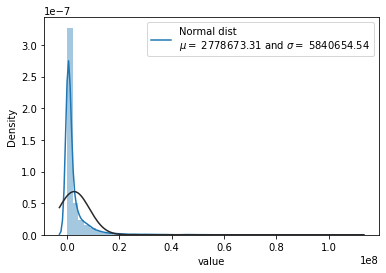

In [ ]:
sns.distplot(train_data.value, fit = norm)
(mu, sigma) = norm.fit(train_data['value'])
plt.legend(['Normal dist\n$\mu=$ {:.2f} and $\sigma=$ {:.2f}'.format(mu, sigma)], loc = 'best')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


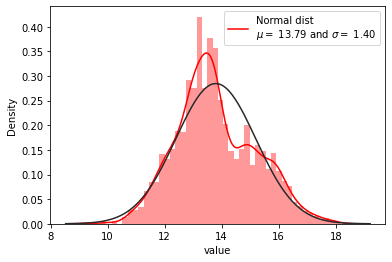

In [ ]:
sns.distplot(np.log1p(train_data.value), fit = norm, color = 'r')
(mu, sigma) = norm.fit(np.log1p(train_data['value']))
plt.legend(['Normal dist\n$\mu=$ {:.2f} and $\sigma=$ {:.2f}'.format(mu, sigma)],loc = 'best')
plt.show()

In [ ]:
train_data.value = np.log1p(train_data.value)

In [ ]:
train_data.head()

,age,continent,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
0,31,south america,ST,left,5.0,94,94,4.0,18.520526
1,27,europe,GK,right,4.0,91,93,1.0,18.092177
2,31,south america,ST,right,5.0,91,91,3.0,18.197537
3,32,europe,DF,right,4.0,91,91,3.0,17.747336
4,25,europe,GK,right,3.0,90,93,1.0,18.035018


**텍스트 데이터의 One-hot encoding 처리**

pandas의 get_dummies() 함수를 사용하기

In [ ]:
train_data = pd.get_dummies(columns=['continent', 'position', 'prefer_foot'], data=train_data)
test_data = pd.get_dummies(columns=['continent', 'position', 'prefer_foot'], data=test_data)

In [ ]:
train_data.head()

,age,reputation,stat_overall,stat_potential,stat_skill_moves,value,continent_africa,continent_asia,continent_europe,continent_oceania,continent_south america,position_DF,position_GK,position_MF,position_ST,prefer_foot_left,prefer_foot_right
0,31,5.0,94,94,4.0,18.520526,0,0,0,0,1,0,0,0,1,1,0
1,27,4.0,91,93,1.0,18.092177,0,0,1,0,0,0,1,0,0,0,1
2,31,5.0,91,91,3.0,18.197537,0,0,0,0,1,0,0,0,1,0,1
3,32,4.0,91,91,3.0,17.747336,0,0,1,0,0,1,0,0,0,0,1
4,25,3.0,90,93,1.0,18.035018,0,0,1,0,0,0,1,0,0,0,1


**모델 생성 및 학습 (Linear Regression)**

Train, Validation Data 생성하기

In [ ]:
X = train_data.drop('value', axis=1)
y = train_data.value
x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

학습하기

In [ ]:
lr = LinearRegression()
lr.fit(x_train, y_train)

LinearRegression()

In [ ]:
print(lr.coef_)
print(lr.intercept_)

[-9.99215386e-02  4.84851865e-03  2.24147885e-01 -5.75954351e-03
  3.97384533e-02  4.43537503e-03  2.48027310e-02 -7.16996812e-03
 -2.19174951e-02 -1.50642737e-04 -5.95705408e-02 -1.26616941e-01
  6.73546384e-02  1.18832843e-01 -5.22616423e-03  5.22616423e-03]
1.5703526328437825


검증하기

Training Data와 Validation Data에 대해서
RMSE(Root Mean Squared Error)와 R2 계수를 구해서 체크해 보기

In [ ]:
accuracy_check_lr = {}

In [ ]:
y_pred = lr.predict(x_train) 
train_r2_score = metrics.r2_score(y_train, y_pred)
train_rmse_score = np.sqrt(metrics.mean_squared_error(y_train, y_pred))
print(train_r2_score, train_rmse_score)
accuracy_check_lr['train_r2_score'] = train_r2_score
accuracy_check_lr['train_rmse_score'] = train_rmse_score

0.9690128150700598 0.24554980911738725


In [ ]:
y_pred = lr.predict(x_valid) 
valid_r2_score = metrics.r2_score(y_valid, y_pred)
valid_rmse_score =  np.sqrt(metrics.mean_squared_error(y_valid, y_pred))
print(valid_r2_score, valid_rmse_score)
accuracy_check_lr['valid_r2_score'] = valid_r2_score
accuracy_check_lr['valid_rmse_score'] = valid_rmse_score

0.9702440208527559 0.24630588072549242


In [ ]:
accuracy_lr = pd.DataFrame(accuracy_check_lr, index=['LR'])
accuracy_lr

,train_r2_score,train_rmse_score,valid_r2_score,valid_rmse_score
LR,0.969013,0.24555,0.970244,0.246306


**모델 생성 및 학습 (SVM - Supported Vector Machine)**

Data 전처리

각 feature가 갖는 값들의 숫자 범위를 일정한 범위로 맞추기 위해 MinMaxScaler 라이브러리를 이용해 값을 0과 1사이 값으로 변환함

In [ ]:
X = train_data.drop('value', axis=1)
y = train_data.value
#scaler = MinMaxScaler()
#scaler.fit(X)
#X = scaler.transform(X)
x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

GridSearchCV를 이용하여 SVM hyperparameter인 C, gamma 값을 최적화함

In [ ]:
def svr_param_selection(X, y, nfolds) :
    svm_parameters = [{'kernel':['rbf'],
                       'gamma':[0.00001, 0.0001, 0.001, 0.01, 0.1, 1],
                       'C':[0.01, 0.1, 1, 10, 100, 1000]}]
    clf = GridSearchCV(SVR(), svm_parameters, cv=nfolds)
    clf.fit(X, y)
    print(clf.best_params_)
    return clf

clf = svr_param_selection(x_train, y_train.values.ravel(), 10)

{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}


검증하기

Training Data와 Validation Data에 대해서
RMSE(Root Mean Squared Error)와 R2 계수를 구해서 체크해 보기

In [ ]:
accuracy_check_svm = {}

In [ ]:
y_pred = clf.predict(x_train) 
train_r2_score = metrics.r2_score(y_train, y_pred)
train_rmse_score = np.sqrt(metrics.mean_squared_error(y_train, y_pred))
print(train_r2_score, train_rmse_score)
accuracy_check_svm['train_r2_score'] = train_r2_score
accuracy_check_svm['train_rmse_score'] = train_rmse_score

0.9963582953289103 0.08400979139233476


In [ ]:
y_pred = clf.predict(x_valid) 
valid_r2_score = metrics.r2_score(y_valid, y_pred)
valid_rmse_score =  np.sqrt(metrics.mean_squared_error(y_valid, y_pred))
print(valid_r2_score, valid_rmse_score)
accuracy_check_svm['valid_r2_score'] = valid_r2_score
accuracy_check_svm['valid_rmse_score'] = valid_rmse_score

0.9955204243830591 0.09631214167300232


In [ ]:
accuracy_svm = pd.DataFrame(accuracy_check_svm, index=['SVM'])
accuracy_svm

,train_r2_score,train_rmse_score,valid_r2_score,valid_rmse_score
SVM,0.996358,0.08401,0.99552,0.096312


**모델 생성 및 학습 (K-NN 알고리즘 )**

Train, Validation Data 생성하기

In [ ]:
X = train_data.drop('value', axis=1)
y = train_data.value
x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

GridSearchCV를 이용하여 K-NN의 neighbor 값을 최적화함

In [ ]:
knr = KNeighborsRegressor()

param_grid = {'n_neighbors':[3, 5, 7, 9, 11]}

grid = GridSearchCV(knr, param_grid=param_grid) 

grid.fit(x_train, y_train)

print(pd.DataFrame(grid.cv_results_).sort_values(by='param_n_neighbors'))
print(grid.best_score_)
print(grid.best_params_)

   mean_fit_time  std_fit_time  ...  std_test_score  rank_test_score
0       0.005167      0.001829  ...        0.001497                5
1       0.004130      0.000148  ...        0.002000                2
2       0.004130      0.000127  ...        0.001832                1
3       0.004226      0.000101  ...        0.001773                3
4       0.004230      0.000220  ...        0.001938                4

[5 rows x 14 columns]
0.9922942946278244
{'n_neighbors': 7}


In [ ]:
knr = grid.best_estimator_

검증하기

Training Data와 Validation Data에 대해서
RMSE(Root Mean Squared Error)와 R2 계수를 구해서 체크해 보기

In [ ]:
accuracy_check_knn = {}

In [ ]:
y_pred = knr.predict(x_train) 
train_r2_score = metrics.r2_score(y_train, y_pred)
train_rmse_score = np.sqrt(metrics.mean_squared_error(y_train, y_pred))
print(train_r2_score, train_rmse_score)
accuracy_check_knn['train_r2_score'] = train_r2_score
accuracy_check_knn['train_rmse_score'] = train_rmse_score

0.9948538020627279 0.1001604802844804


In [ ]:
y_pred = knr.predict(x_valid) 
valid_r2_score = metrics.r2_score(y_valid, y_pred)
valid_rmse_score =  np.sqrt(metrics.mean_squared_error(y_valid, y_pred))
print(valid_r2_score, valid_rmse_score)
accuracy_check_knn['valid_r2_score'] = valid_r2_score
accuracy_check_knn['valid_rmse_score'] = valid_rmse_score

0.993510604791938 0.11463258169199281


In [ ]:
accuracy_knn = pd.DataFrame(accuracy_check_knn, index=['KNN'])
accuracy_knn

,train_r2_score,train_rmse_score,valid_r2_score,valid_rmse_score
KNN,0.994854,0.10016,0.993511,0.114633


**앙상블 모델**

VotingRegressor 모델

In [ ]:
en_lr = LinearRegression()
en_svr = SVR(kernel='rbf', C=10, gamma=0.01)     # 최적의 C, gamma 값의 model 생성
en_knr = KNeighborsRegressor(n_neighbors=7)   # 최적의 neighbor 값의 model 생성

voting_model = VotingRegressor(estimators=[
                      ('LR', en_lr), ('SVM', en_svr), ('KNN', en_knr)],
                      weights=[1, 1, 1])
voting_model.fit(x_train, y_train)

VotingRegressor(estimators=[('LR', LinearRegression()),
                            ('SVM', SVR(C=10, gamma=0.01)),
                            ('KNN', KNeighborsRegressor(n_neighbors=7))],
                weights=[1, 1, 1])

검증하기

Training Data와 Validation Data에 대해서
RMSE(Root Mean Squared Error)와 R2 계수를 구해서 체크해 보기

In [ ]:
accuracy_check_ens = {}

In [ ]:
y_pred = voting_model.predict(x_train) 
train_r2_score = metrics.r2_score(y_train, y_pred)
train_rmse_score = np.sqrt(metrics.mean_squared_error(y_train, y_pred))
print(train_r2_score, train_rmse_score)
accuracy_check_ens['train_r2_score'] = train_r2_score
accuracy_check_ens['train_rmse_score'] = train_rmse_score

0.9933575523555228 0.11379343967286465


In [ ]:
y_pred = voting_model.predict(x_valid) 
valid_r2_score = metrics.r2_score(y_valid, y_pred)
valid_rmse_score =  np.sqrt(metrics.mean_squared_error(y_valid, y_pred))
print(valid_r2_score, valid_rmse_score)
accuracy_check_ens['valid_r2_score'] = valid_r2_score
accuracy_check_ens['valid_rmse_score'] = valid_rmse_score

0.993107870510388 0.11813611259006601


In [ ]:
accuracy_ens = pd.DataFrame(accuracy_check_ens, index=['ENS'])
accuracy_ens

,train_r2_score,train_rmse_score,valid_r2_score,valid_rmse_score
ENS,0.993358,0.113793,0.993108,0.118136


검증결과 시각화

4개 알고리즘의 검증 결과 합치기

In [ ]:
accuracy_result = pd.concat([accuracy_lr, accuracy_svm, accuracy_knn, accuracy_ens])
accuracy_result

,train_r2_score,train_rmse_score,valid_r2_score,valid_rmse_score
LR,0.969013,0.245550,0.970244,0.246306
SVM,0.996358,0.084010,0.995520,0.096312
KNN,0.994854,0.100160,0.993511,0.114633
ENS,0.993358,0.113793,0.993108,0.118136


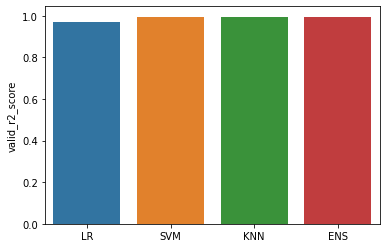

In [ ]:
sns.barplot(data=accuracy_result, x=accuracy_result.index, y='valid_r2_score')

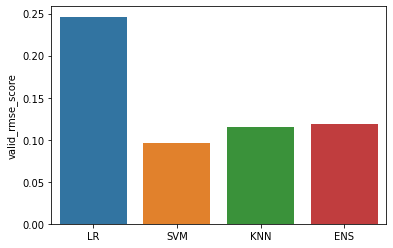

In [ ]:
sns.barplot(data=accuracy_result, x=accuracy_result.index, y='valid_rmse_score')

테스트 데이터로 예측값 산출하기

4개 알고리즘을 비교했을 때 SVM알고리즘이 정확도가 가장 뛰어난 것으로 확인됨
따라서 SVM 알고리즘으로 테스트 데이터 값을 예측함.

In [ ]:
exp_value = np.expm1(clf.predict(test_data))

In [ ]:
test['value'] = exp_value

In [ ]:
final = test[['id', 'name', 'value']]
final.head()

,id,name,value
0,1,Cristiano Ronaldo,6.005809e+07
1,2,Neymar Jr,7.709454e+07
2,4,K. De Bruyne,9.008098e+07
3,5,E. Hazard,8.873260e+07
4,6,L. Modrić,6.232264e+07
